In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.plotting import plot_trajectory
from utils.processing import (
    open_file,
    cut_jumps
    )

DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'preprocessed_dataset/for_lebedevs_code'

In [2]:
def open_preprocessed_data(fname):
    with open(fname, 'rb') as inp:
        sub_trajs_list = pickle.load(inp)
    return sub_trajs_list

DT = '03'
# DT = 'orig'
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

df_dict = {}
for k in dfs_names:
    sub_traj_df = open_preprocessed_data(f'{PREPROC_DATA_DIR}/{k}_{DT}_dt.pkl')
    df_concat = pd.concat(sub_traj_df)
    df_dict[k] = df_concat

In [3]:
# sub_traj_df = df_dict['tr7']#[150:160]
# sub_traj_df

sub_traj_df = open_preprocessed_data(f'{PREPROC_DATA_DIR}/tr7_{DT}_dt.pkl')
sub_traj_df[0].shape

(252, 6)

In [4]:
df_dict['tr7'].shape

(5010, 6)

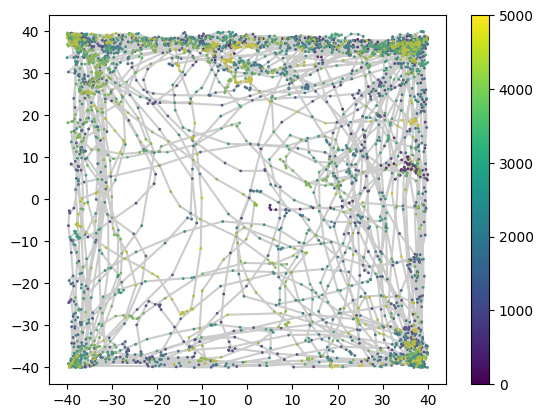

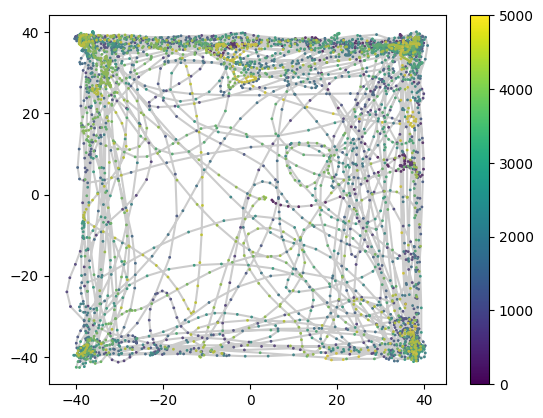

In [5]:
# from buzsaki_regress.m
from scipy.signal import butter, filtfilt

def smooth_data(sig, N=6, Wn=0.15):
    # param to change: the lower Wn, the smoother traj 
    b, a = butter(N, Wn, 'low')
    sig_smoothed = filtfilt(b, a, sig)
    return sig_smoothed

# df_dict = open_preprocessed_data(f'{PREPROC_DATA_DIR}/tr7_{DT}_dt.pkl')
sub_traj_df = df_dict['tr7']
# sub_traj_df = df_dict['tr7'][:595]
plot_trajectory(sub_traj_df['x'], sub_traj_df['y'],
                center_mark=False)

# for "NEW_DT = 0.0335 * 9 # basic", Wn=0.15
# for "ORIG_DT = 0.0335", Wn=0.02
xx = smooth_data(sub_traj_df['x'], N=6, Wn=0.2)
yy = smooth_data(sub_traj_df['y'], N=6, Wn=0.2)
plot_trajectory(xx, yy, center_mark=False)

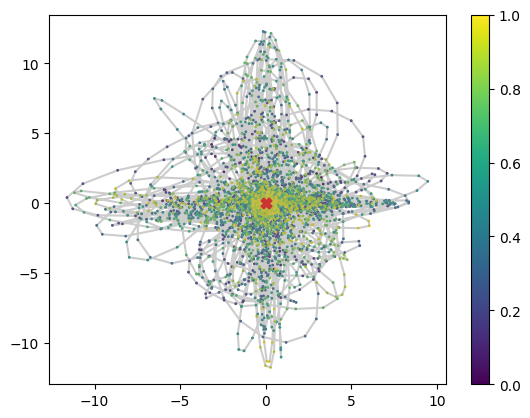

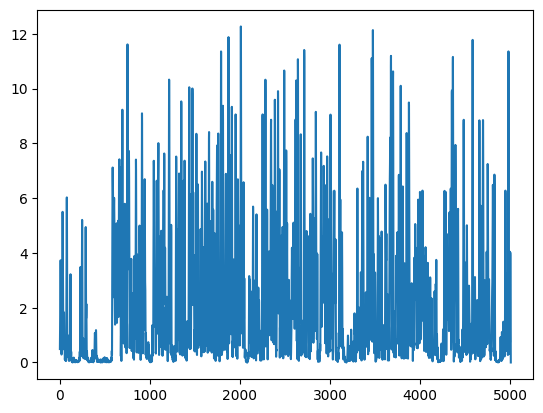

------------------------------


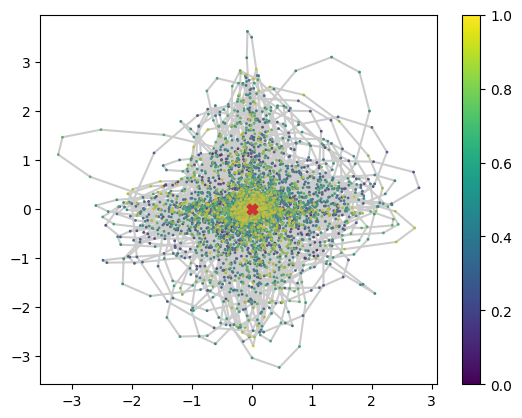

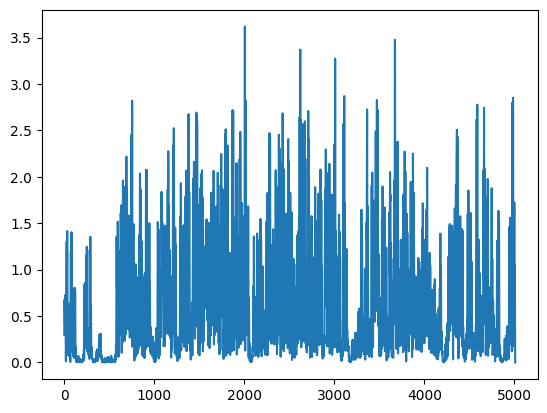

------------------------------


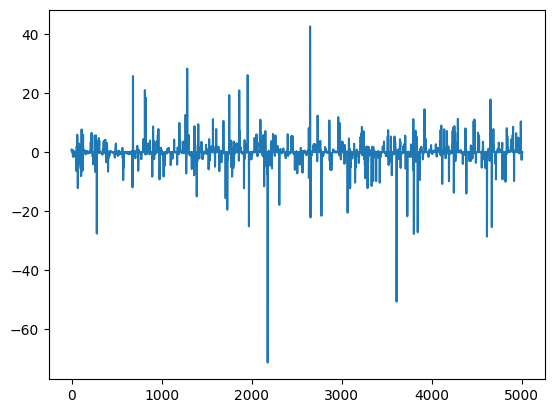

In [9]:
# Calculate velocity and speed
vx = np.diff(xx, append=xx[-1])
vy = np.diff(yy, append=yy[-1])
s = np.sqrt(vx**2 + vy**2)

plot_trajectory(vx, vy)
plt.plot(s)
plt.show()
print('-'*30)

# Calculate acceleration
ax = np.diff(vx, append=vx[-1])
ay = np.diff(vy, append=vy[-1])
a = np.sqrt(ax**2 + ay**2)
plot_trajectory(ax, ay)
plt.plot(a)
plt.show()
print('-'*30)

# Calculate curvature
c = (vx * ay - vy * ax) / ((np.power(vx**2 + vy**2, 1.5)) + 1e-3)
plt.plot(c)
plt.show()

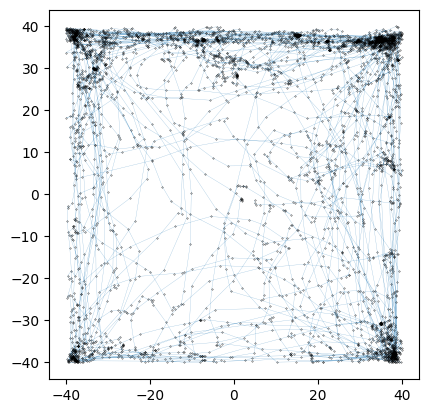

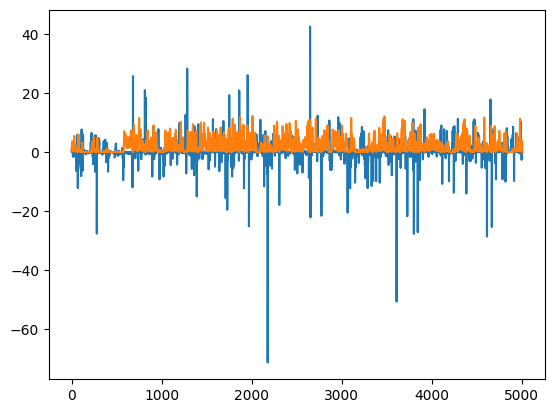

median_c_to_s_ratio:  0.06048420356399044


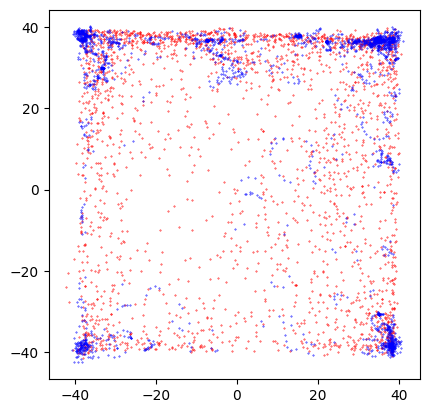

In [10]:
# fig 1
x = sub_traj_df['x'].to_numpy()
y = sub_traj_df['y'].to_numpy()

plt.figure(1)
plt.plot(x, y, '.k', markersize=0.5, zorder=2)
plt.plot(x, y, lw=0.2, alpha=0.5, zorder=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure(2)
# Calculate curvature to speed ratio and find indices
# for lower and higher than median values
c_nonzero = np.where(c==0, 1e-3, c)
s_nonzero = np.where(s==0, 1e-3, s)
plt.plot(c)
plt.plot(s)
plt.show()
c_to_s_ratio = np.abs(c_nonzero / s_nonzero)    # NOTE: another way to define stops?
median_c_to_s_ratio = np.median(c_to_s_ratio)
print('median_c_to_s_ratio: ', median_c_to_s_ratio)
II_low = np.where(c_to_s_ratio < median_c_to_s_ratio)[0]
II_high = np.where(c_to_s_ratio >= median_c_to_s_ratio)[0]

# Plot segments with lower than median ratio in red
plt.plot(xx[II_low], yy[II_low], '.r', markersize=0.7)
# Plot segments with higher than median ratio in blue
plt.plot(xx[II_high], yy[II_high], '.b', markersize=0.7)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

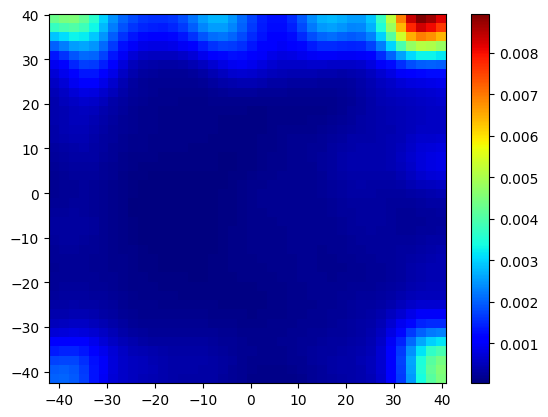

In [11]:
# Density Calculation and Gaussian Filtering

from scipy.ndimage import gaussian_filter

N, xedges, yedges = np.histogram2d(xx, yy, bins=40, density=True)

N = N / np.sum(N)
NN = gaussian_filter(N, sigma=2)
plt.pcolormesh(xedges, yedges,
               NN.T, shading='flat', cmap='jet')
plt.colorbar()
# plt.clim(0, 0.0035) # clip values
plt.show()

NN = gaussian_filter(N, sigma=3)

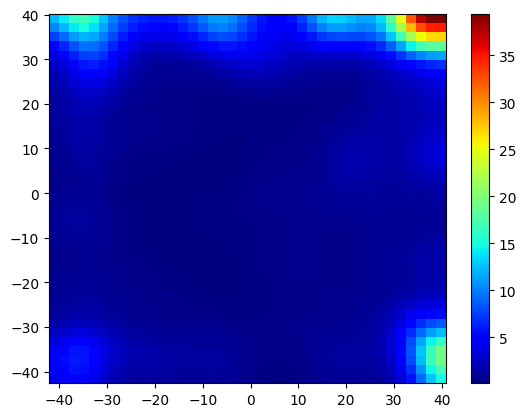

In [12]:
from scipy.ndimage import gaussian_filter

S = np.zeros((len(xedges)-1, len(yedges)-1))
N_matrix = np.zeros_like(S)

a = N.mean()

L = 1  # Define radius

for ix in range(len(xedges)-1):
    for iy in range(len(yedges)-1):
        x0 = xedges[ix]
        y0 = yedges[iy]
        
        # Find points within radius L from the center of the current cell
        III = np.where(((x - x0) ** 2 + (y - y0) ** 2) < (L ** 2))[0]
        
        if III.size > 0:
            condition_met = np.sum(np.abs(s[III]) > np.median(np.abs(s)))
            S[ix, iy] = condition_met / III.size  # Proportion of points meeting condition
            S[ix, iy] = III.size > a  # Whether the number of points is greater than the average
            N_matrix[ix, iy] = III.size
        else:
            S[ix, iy] = 0
            N_matrix[ix, iy] = 0

SS = gaussian_filter(S, sigma=2)
NN = gaussian_filter(N_matrix, sigma=2)  # Use N_matrix to avoid confusion with histogram N

# plt.pcolormesh(xedges, yedges, SS.T,
#                cmap='jet', shading='flat')  # Transpose SS for correct orientation
plt.pcolormesh(xedges, yedges, NN.T,
               cmap='jet', shading='flat')  # Transpose SS for correct orientation
plt.colorbar()
plt.show()

**Positive Divergence**: When the divergence at a point in space is positive, it indicates that the vector field (or flow) is diverging from that point. In practical terms, this means the area is behaving like a source, with entities moving away from the point. For mice trajectories, a positive divergence could indicate regions where mice tend to start separating from each other or spreading out, suggesting an avoidance behavior or dispersion from a common point.

**Negative Divergence**: Conversely, when the divergence is negative, it implies that the vector field is converging to that point, making it act like a sink. In the context of mice movements, a negative divergence could indicate regions where mice are coming together or converging, possibly indicating attractor points, gathering areas, or following behavior towards a common destination.

**Zero or Near-Zero Divergence**: Points with zero or near-zero divergence are areas where the flow neither converges nor diverges significantly. This could mean that the movement is relatively uniform in these areas, with no significant gathering or dispersing behavior among the mice.

Understanding the divergence in the context of animal movements or similar phenomena can provide valuable insights into behavioral patterns, such as social gathering points, avoidance areas, or pathways of movement within an environment.

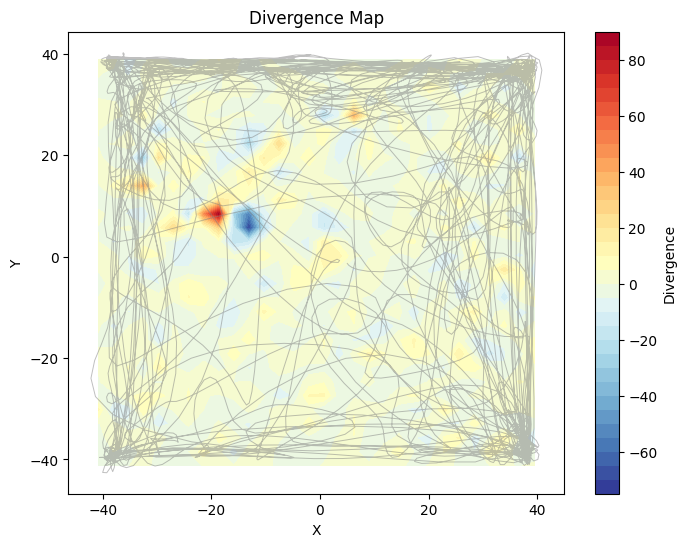

In [13]:
Vx = np.gradient(xx)
Vy = np.gradient(yy)

n_bins = 30
N, x_edges, y_edges = np.histogram2d(xx, yy, bins=n_bins, density=True)

# Create a 2D grid for the velocity components
X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

from scipy.interpolate import griddata
Vx_grid = griddata((x, y), Vx, (X, Y), method='cubic', fill_value=0)
Vy_grid = griddata((x, y), Vy, (X, Y), method='cubic', fill_value=0)

Vx_grad_x, Vx_grad_y = np.gradient(Vx_grid, axis=(1, 0))
Vy_grad_x, Vy_grad_y = np.gradient(Vy_grid, axis=(1, 0))

divergence = Vx_grad_x + Vy_grad_y

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, divergence, 
            levels=35,  # increase this param to "interpolate"
             cmap='RdYlBu_r')
plt.colorbar(label='Divergence')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Divergence Map')

# plot traj
time_cmap = np.arange(0, len(xx))
plt.plot(xx, yy, alpha=0.5, c='grey', lw=0.7)
# plt.scatter(xx, yy, alpha=0.5, c=time_cmap, marker='o',
            # s=4)
# plot vec. field TODO
plt.show()

# negative => attractor
# positive => divergent point

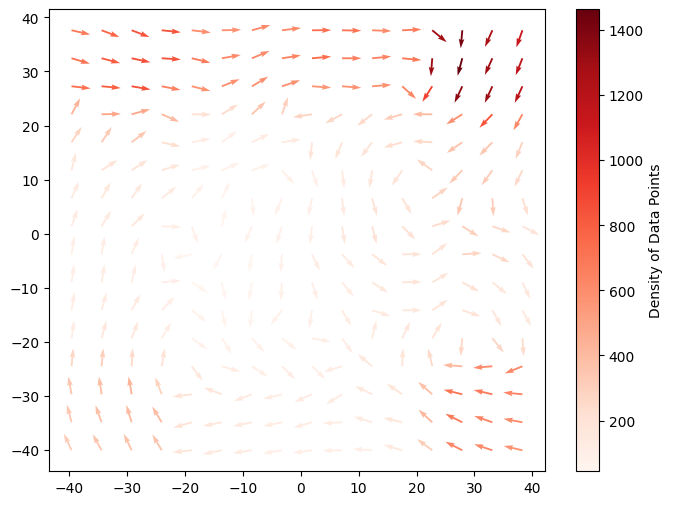

In [14]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

NNN, xedges, yedges = np.histogram2d(xx, yy, bins=16)

X, Y, U, V, Densities = [], [], [], [], []

L = 15  # Radius for neighborhood calculations
# param to change

for ix in range(len(xedges)-1):
    for iy in range(len(yedges)-1):
        x0 = (xedges[ix] + xedges[ix+1]) / 2
        y0 = (yedges[iy] + yedges[iy+1]) / 2
        
        mask = ((x - x0) ** 2 + (y - y0) ** 2) < L**2
        selected_vx = vx[mask]
        selected_vy = vy[mask]
        
        if len(selected_vx) > 0:
            d = np.mean(selected_vx + 1j * selected_vy)
            d /= np.abs(d) ** 0.6
            
            X.append(x0)
            Y.append(y0)
            U.append(np.real(d))
            V.append(np.imag(d))
            Densities.append(len(selected_vx))

max_density = max(Densities)
min_density = min(Densities)
normalized_densities = [(d - min_density) / (max_density - min_density) for d in Densities]
# normalized_densities = Densities  # TODO ?
colors = [cm.Reds(density) for density in normalized_densities]

fig, ax = plt.subplots(figsize=(8, 6))
magnitude = np.sqrt(np.asarray(U)**2 + np.asarray(V)**2)
magnitude[magnitude == 0] = 1
U_normalized = U / magnitude
V_normalized = V / magnitude

# normalize colors TODO ??
# colors = np.asarray(colors)
# colors = (colors - np.amin(colors)) / (np.amax(colors) - np.amin(colors))
# colors = list(colors)

q = ax.quiver(X, Y, U_normalized, V_normalized,
              color=colors, 
              scale_units='xy', 
              # scale=np.ones((12**2))-0.5, 
              scale=0.3,
              angles='xy'
              )

sm = cm.ScalarMappable(cmap=cm.Reds,
                       norm=Normalize(vmin=min_density,
                                      vmax=max_density))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Density of Data Points')
plt.show()

### Make functions

In [121]:
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.processing import rescale_coord


def smooth_data(sig, N=6, Wn=0.15):
    # param to change: the lower Wn, the smoother traj 
    b, a = butter(N, Wn, 'low')
    sig_smoothed = filtfilt(b, a, sig)
    return sig_smoothed


def calc_velocity_and_speed(xx, yy):
    vx = np.diff(xx, append=xx[-1])
    vy = np.diff(yy, append=yy[-1])
    s = np.sqrt(vx**2 + vy**2)
    return vx, vy, s


def calc_acceleration(vx, vy):
    ax = np.diff(vx, append=vx[-1])
    ay = np.diff(vy, append=vy[-1])
    a = np.sqrt(ax**2 + ay**2)
    return ax, ay, a


def calc_curvature(vx, vy, ax, ay):
    c = (vx * ay - vy * ax) / ((np.power(vx**2 + vy**2, 1.5)) + 1e-3)
    return c


def plot_trajectory_with_median(xx, yy):
    """
    Calculate curvature to speed ratio and find indices
    for lower and higher than median values
    """
    vx, vy, s = calc_velocity_and_speed(xx, yy)
    ax, ay, a = calc_acceleration(vx, vy)
    c = calc_curvature(vx, vy, ax, ay)

    c_nonzero = np.where(c==0, 1e-3, c)
    s_nonzero = np.where(s==0, 1e-3, s)

    c_to_s_ratio = np.abs(c_nonzero / s_nonzero)    # NOTE: another way to define stops?
    median_c_to_s_ratio = np.median(c_to_s_ratio)
    II_low = np.where(c_to_s_ratio < median_c_to_s_ratio)[0]
    II_high = np.where(c_to_s_ratio >= median_c_to_s_ratio)[0]

    # Plot segments with lower than median ratio in red
    plt.plot(xx[II_low], yy[II_low], '.r', markersize=0.7)
    # Plot segments with higher than median ratio in blue
    plt.plot(xx[II_high], yy[II_high], '.b', markersize=0.7)
    plt.plot(xx, yy, 'grey', alpha=0.2, lw=0.7)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


def plot_vector_field(xx, yy, L=15, n_bins=16,
                      ax=None, fig=None):
    """
    L: Radius for neighborhood calculations
    """
    NN, xedges, yedges = np.histogram2d(xx, yy, bins=n_bins)
    X, Y, U, V, Densities = [], [], [], [], []
    vx, vy, s = calc_velocity_and_speed(xx, yy)
    for ix in range(len(xedges)-1):
        for iy in range(len(yedges)-1):
            x0 = (xedges[ix] + xedges[ix+1]) / 2
            y0 = (yedges[iy] + yedges[iy+1]) / 2
            
            mask = ((xx - x0) ** 2 + (yy - y0) ** 2) < L**2
            selected_vx = vx[mask]
            selected_vy = vy[mask]
            
            if len(selected_vx) > 0:
                d = np.mean(selected_vx + 1j * selected_vy)
                d /= np.abs(d) ** 0.6
                X.append(x0)
                Y.append(y0)
                U.append(np.real(d))
                V.append(np.imag(d))
                Densities.append(len(selected_vx))
    max_density = max(Densities)
    min_density = min(Densities)
    normalized_densities = [(d - min_density) / (max_density - min_density) for d in Densities]
    colors = [cm.Reds(density) for density in normalized_densities]

    if not ax:
        fig, ax = plt.subplots(figsize=(8, 6))
    magnitude = np.sqrt(np.asarray(U)**2 + np.asarray(V)**2)
    magnitude[magnitude == 0] = 1
    U_normalized = U / magnitude
    V_normalized = V / magnitude
    q = ax.quiver(X, Y, U_normalized, V_normalized,
                color=colors, 
                scale_units='xy', 
                scale=0.3,
                angles='xy')
    sm = cm.ScalarMappable(cmap=cm.Reds,
                           norm=Normalize(vmin=min_density,
                                          vmax=max_density))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax,
                        label='Density of Data Points')
    if not ax:
        plt.show()


def min_max_norm(sig):
    sig_ = (sig - np.amin(sig)) / (np.amax(sig) - np.amin(sig))
    return sig_


def plot_occupancy(xx, yy, sigma=2,
                   clip=None, n_bins=40,
                   ax=None, fig=None):
    N, xedges, yedges = np.histogram2d(xx, yy,
                                       bins=n_bins,
                                       density=True)
    # N = N / np.sum(N)
    N = min_max_norm(N)
    NN = gaussian_filter(N, sigma=sigma)
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.pcolormesh(xedges, yedges,
                   NN.T, shading='flat', cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    if clip:
        plt.clim(0, clip) # 0.0035, clip values
    if not ax:
        plt.show()


def plot_occupancy_median(xx, yy, sigma=2,
                          L=2, n_bins=40, 
                          ax=None, fig=None):
    """
    L: radius
    """
    N, xedges, yedges = np.histogram2d(xx, yy,
                                       bins=n_bins,
                                       density=True)
    N = N / np.sum(N)
    a = N.mean()

    S = np.zeros((len(xedges)-1, len(yedges)-1))
    for ix in range(len(xedges)-1):
        for iy in range(len(yedges)-1):
            x0 = xedges[ix]
            y0 = yedges[iy]
            
            # Find points within radius L from the center of the current cell
            III = np.where(((x - x0) ** 2 + (y - y0) ** 2) < (L ** 2))[0]
            
            if III.size > 0:
                condition_met = np.sum(np.abs(s[III]) > np.median(np.abs(s)))
                S[ix, iy] = condition_met / III.size  # Proportion of points meeting condition
                # Whether the number of points is greater than the average
                S[ix, iy] = III.size > a  
    SS = gaussian_filter(S, sigma=sigma)
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.pcolormesh(xedges, yedges, SS.T,
                       cmap='jet', shading='flat')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if not ax:
        plt.show()


def plot_divergence(xx, yy, n_bins=30, level=35, scaling=True,
                    ax=None, fig=None):
    Vx = np.gradient(xx)
    Vy = np.gradient(yy)

    N, x_edges, y_edges = np.histogram2d(xx, yy,
                                         bins=n_bins,
                                         density=True)
    # Create a 2D grid for the velocity components
    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

    Vx_grid = griddata((xx, yy), Vx, (X, Y), method='cubic', fill_value=0)
    Vy_grid = griddata((xx, yy), Vy, (X, Y), method='cubic', fill_value=0)

    Vx_grad_x, Vx_grad_y = np.gradient(Vx_grid, axis=(1, 0))
    Vy_grad_x, Vy_grad_y = np.gradient(Vy_grid, axis=(1, 0))

    divergence = Vx_grad_x + Vy_grad_y
    # Scale with sqrt and keep sign
    if scaling:
        divergence = rescale_coord(divergence, new_min=-1, new_max=1)
        divergence = np.sign(divergence) * np.sqrt(np.abs(divergence))

    if not ax:
        fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.contourf(X, Y, divergence, 
                    levels=level,  # increase this param to "interpolate"
                    cmap='RdYlBu_r')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Divergence Map')
    if not ax:
        plt.show()

### Now we check that everything is working!

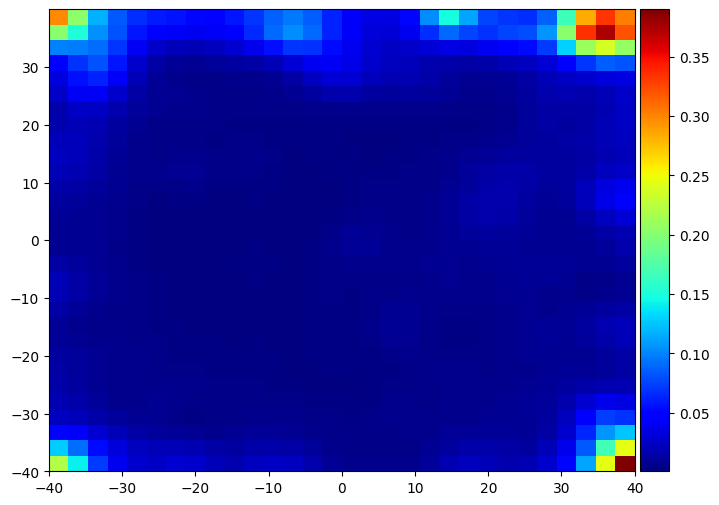

In [41]:
# plot_trajectory_with_median(xx, yy)

# plot_vector_field(xx, yy, L=15, n_bins=16, ax=None)
# fig, ax = plt.subplots(1,2, figsize=(12, 4))
# plot_vector_field(xx, yy, L=15, n_bins=16, ax=ax[0], fig=fig)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot_occupancy(xx, yy, sigma=2, clip=None, n_bins=40, 
#                ax=ax[0], fig=fig)
plot_occupancy(xx, yy, sigma=1, clip=None, n_bins=30, ax=None)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot_occupancy_median(xx, yy, sigma=2, L=2, n_bins=40, 
#                       ax=ax[1], fig=fig)
# plot_occupancy_median(xx, yy, sigma=2, L=2, n_bins=40)

# plot_divergence(xx, yy, n_bins=30, level=35)
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot_divergence(xx, yy, n_bins=30, level=35,
#                 ax=ax[0], fig=fig)

### Compare with our versions


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns

from utils.processing import open_preprocessed_data, df_minmax, add_filtered_V

In [42]:
def occupMapNorm(df, binn, eps=0.1):
    """ 
    делаем df где будет понятно сколько было точек в каждом бине 
    соответсвуеющему данному интервалу х и данному интервалу у
    """
    xmin = df["x"].min() - eps
    xmax = df["x"].max() + eps
    binx = np.linspace(xmin, xmax, binn)
    x_cut = pd.cut(df.x, binx, right=False)

    ymin = df["y"].min() - eps
    ymax = df["y"].max() + eps
    biny = np.linspace(ymin, ymax, binn)
    y_cut = pd.cut(df.y, biny, right=False)

    dfn = df.groupby([x_cut, y_cut], observed=False).count()
    
    dfn = dfn.drop(columns=['x', 'y'])
    dfn = dfn.rename(columns={'time': 'Count'})
    
    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))
    
    dd = dfm.unstack()
    arrd = dd.replace(0., 1).to_numpy()
    arrl = np.log(arrd)

    arrl = df_minmax(arrl)
    return arrl

def plot_occupancy_plot(df, n_bins=30, sigma=1,
                        ax=None, fig=None):
    df_copy = df[['time', 'x', 'y']]
    occ = occupMapNorm(df_copy, binn=n_bins)

    occ_s = gaussian_filter(occ, sigma=sigma)
    plt.imshow(occ_s, cmap='jet', interpolation='none') 
    plt.colorbar()
    plt.show()

    
def calc_divergence(df, binn):
    dx, dy = df['x'].diff(), df['y'].diff()
    dx.iloc[0], dy.iloc[0] = 0., 0.

    div = df['Vx']/dx + df['Vy']/dy
    df['divergence'] = div

    binx = np.linspace(df["x"].min(), df["x"].max(), binn)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), binn)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut], observed=False).mean()
    dfn = pd.DataFrame(dfn.loc[:, 'divergence'])
    dfn = dfn.unstack()
    dfn = dfn.fillna(0)

    dfn = df_minmax(dfn)
    return dfn

def plot_divergence_old(df, n_bin=18):
    df_v = add_filtered_V(df, smooth_kern=None)
    div_map = calc_divergence(df, binn=n_bin)
    sns.heatmap(div_map, robust=False, square=True,
                # xticklabels=False, yticklabels=False)
    )
    plt.show()

In [43]:
def divMap(df, n):
    df = df.reset_index()

    ind = range(0, len(df))
    df = df.reindex(ind)
    vx = []
    vy = []
    div = []
    for i in range(len(df)):
        if i == 0:
            vx.append(0)
            vy.append(0)
            div.append(0)
        elif (df['x'][i]-df['x'][i-1])==0 or (df['y'][i]-df['y'][i-1])==0:
            vx.append((df['x'][i]-df['x'][i-1])/(df['time'][i]-df['time'][i-1]))
            vy.append((df['y'][i]-df['y'][i-1])/(df['time'][i]-df['time'][i-1]))
            div.append(0)
        else:
            dx = df['x'][i]-df['x'][i-1]
            dy = df['y'][i]-df['y'][i-1]
            dt = df['time'][i]-df['time'][i-1]
            vvx = dx/dt
            vvy = dy/dt
            vx.append(vvx)
            vy.append(vvy)
            div.append(vvx/dx + vvy/dy)
    
    df.insert(3, "Vx", vx)
    df.insert(4, "Vy", vy)
    df.insert(5, "divergence", div)
    binx = np.linspace(df["x"].min(), df["x"].max(), n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut]).mean()
    dfn = pd.DataFrame(dfn.loc[:, 'divergence'])
    dfn = dfn.unstack()
    #заменим nan на 0
    dfn = dfn.fillna(0)
    #зашьем в керл минмакс
    dfn = df_minmax(dfn)
    sns.heatmap(dfn, robust=False, square=True, xticklabels=False, yticklabels=False)
    plt.show()
    return dfn

In [44]:
df_test = df_dict['tr7']
df_test

,time,x,y,angles,delta_angle,step_length
0,1.0010,5.034041,-1.379502,0.000000,0.000000,0.000000
1,1.3025,4.951226,-1.954044,188.202190,188.202190,0.580480
2,1.6040,5.197575,-2.434154,152.837242,324.635052,0.539623
3,1.9055,6.327995,-2.434154,90.000000,297.162758,1.130420
4,2.2070,8.581055,-2.422211,89.696289,359.696289,2.253092
...,...,...,...,...,...,...
5,1634.2055,35.092084,-38.086644,81.535249,351.228572,10.373444
6,1634.5070,36.828788,-38.376860,99.486879,17.951630,1.760785
7,1634.8085,37.503479,-38.478991,98.607772,359.120893,0.682377
8,1635.1100,37.859405,-38.295647,62.746208,324.138437,0.400372


In [ ]:
# 1. take our occup but with new colormap
# 2. take lebedev's divergence
# 3. vector fields are different, but have the same coarse-grained dynamics, Need to find the exact differences between two functions
    #for now lets use both of them 

In [67]:
df_test = df_dict['tr7']
df_test.shape

(5010, 6)

In [ ]:
def plot_occupancy_plot(df, n_bins=30, sigma=1,
                        ax=None, fig=None):
    df_copy = df[['time', 'x', 'y']]
    occ = occupMapNorm(df_copy, binn=n_bins)

    occ_s = gaussian_filter(occ, sigma=sigma)
    plt.imshow(occ_s, cmap='jet', interpolation='none') 
    plt.colorbar()
    plt.show()

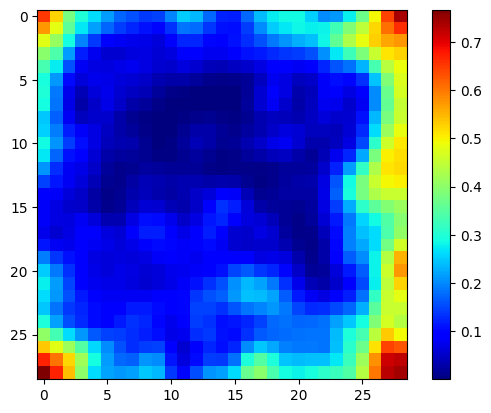

In [68]:
from scipy.ndimage import fourier_gaussian

B = 30
df_copy = df_test[['time', 'x', 'y']]
occ = occupMapNorm(df_copy, binn=B)

occ_s = gaussian_filter(occ, sigma=1)

plt.imshow(occ_s, cmap='jet', interpolation='none') 
plt.colorbar()
plt.show()

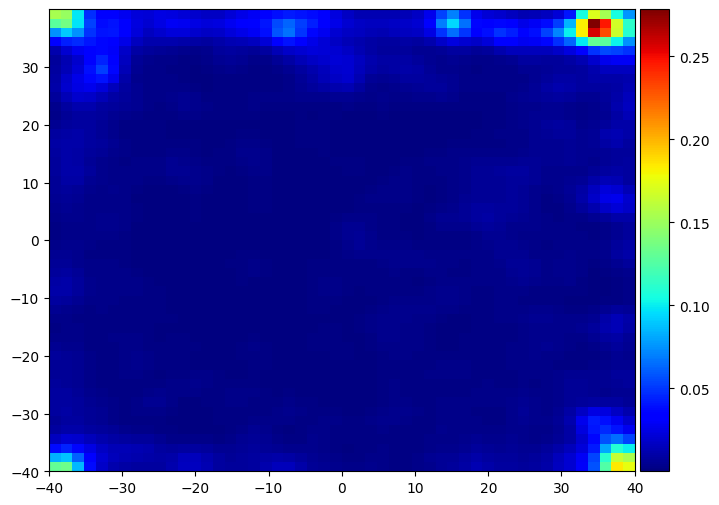

In [70]:
xx = df_copy['x']
yy = df_copy['y'] 
plot_occupancy(xx, yy, sigma=1,
               clip=None, n_bins=B,
                ax=None)

/tmp/ipykernel_9829/3728226138.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfn = df.groupby([x_cut, y_cut]).mean()


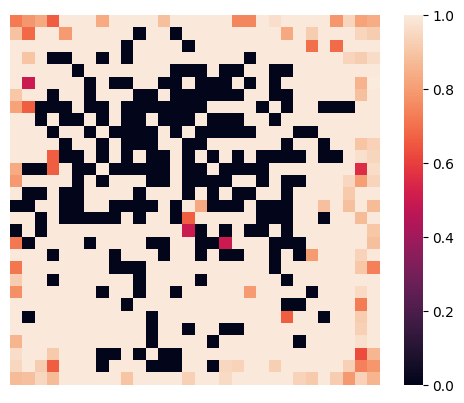

In [72]:
# divergence
B = 30
df_copy = df_test[['time', 'x', 'y']]
d = divMap(df_copy, B)

/home/kate/Documents/navigation/utils/processing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vx'] = vx
/home/kate/Documents/navigation/utils/processing.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vy'] = vy


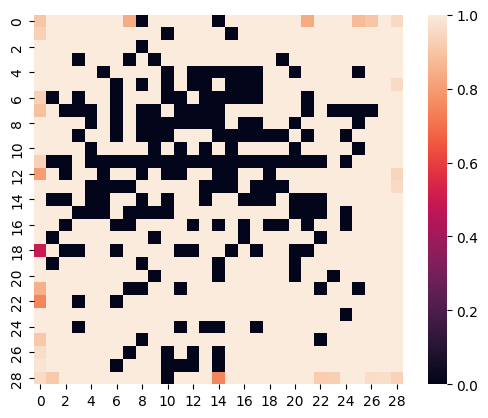

In [73]:
plot_divergence_old(df_copy, B)

1.0 -1.0


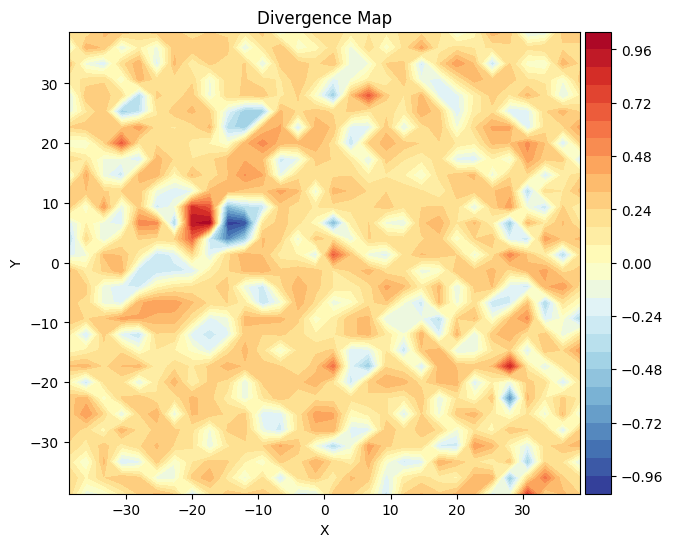

In [92]:
xx = df_copy['x']
yy = df_copy['y'] 
plot_divergence(xx, yy, n_bins=B, level=25)

In [131]:
# vector field
def minmax_normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def speed_z_score_norm(vx, vy, mean, sd, eps=1e-2):
    vb = ((vx ** 2) + (vy ** 2)) ** 0.5
    vn = abs((vb - mean) / (sd + eps))

    vx = vn * vx / (vb + eps)
    vy = vn * vy / (vb + eps)
    return vx, vy


def kill_nans(x, grid_size, verbose=False):
    for i in range(grid_size):
        for j in range(grid_size):
            if np.isnan(x.iloc[i, j]):
                if verbose:
                    print(f'NaN in place: {i}, {j}')
                idx_list = np.array([[i-1, j-1], [i-1, j], [i-1, j+1],
                                        [i, j-1]  ,           [i, j+1],
                                        [i+1, j-1], [i+1, j], [i+1, j+1]])
                
                idx_to_drop = np.where((idx_list < 0) | (idx_list > grid_size-1))[0]
                if verbose:
                    print(f'Dropping indexes: {idx_to_drop}')
                dropping_mask = np.ones(idx_list.shape[0], dtype=bool)
                dropping_mask[idx_to_drop] = False
                idx_list = idx_list[dropping_mask]

                x.iloc[i, j] = np.nanmean(x.iloc[idx_list[:, 0], idx_list[:, 1]])
    return x

import os

def build_vector_field(df, grid_size,
                       title_name, z_norm,
                       lscale=0.17, color_map='Reds',
                       eps=1e-2, unsmoothed_colors=False, save=False):
    
    df = df.reset_index(drop=True)
    binx = np.linspace(df["x"].min() - eps, df["x"].max() + eps,
                       grid_size+1)
    x_binned = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min() - eps, df["y"].max() + eps,
                       grid_size+1)
    y_binned = pd.cut(df.y, biny, right=False)

    df_binned_mean = df.groupby([x_binned, y_binned],
                                 observed=False).mean()
    dfvx = pd.DataFrame(df_binned_mean.loc[:, 'Vx']).unstack()
    dfvy = pd.DataFrame(df_binned_mean.loc[:, 'Vy']).unstack()

    # For z_normalization
    if z_norm:
        df_binned_sd = df.groupby([x_binned, y_binned],
                                observed=False).std()
        mV = pd.DataFrame(df_binned_mean.loc[:, 'V']).unstack()
        sdV = pd.DataFrame(df_binned_sd.loc[:, 'V']).unstack()
        mV =  kill_nans(mV, grid_size, verbose=False)
        sdV = kill_nans(sdV, grid_size, verbose=False)

    # Average Nans with all neightboring values
    dfvx = kill_nans(dfvx, grid_size)
    dfvy = kill_nans(dfvy, grid_size)

    vector_field_matrix = []
    for i in range(grid_size):
        vector_column = []
        for j in range(grid_size):
            if z_norm:
                vx, vy = speed_z_score_norm(dfvx.iloc[i, j], dfvy.iloc[i, j],
                                            mV.iloc[i, j], sdV.iloc[i, j]) 
            else: 
                vx = dfvx.iloc[i, j]
                vy = dfvy.iloc[i, j]

            vector_column.append([binx[i], biny[j], vx, vy])
        vector_field_matrix.append(vector_column)

    vector_field_matrix = np.array(vector_field_matrix)

    vectx = vector_field_matrix[:, :, 2]
    vecty = vector_field_matrix[:, :, 3]

    vectx_smoothed = gaussian_filter(vectx, sigma=2)
    vecty_smoothed = gaussian_filter(vecty, sigma=2)

    L_matrix = (vectx_smoothed**2 + vecty_smoothed**2)**0.5
    L_matrix_unsmoothed = (vectx**2 + vecty**2)**0.5 

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.axvline(0, c='black', alpha=0.2)
    ax.axhline(0, c='black', alpha=0.2)
    
    L = L_matrix_unsmoothed if unsmoothed_colors else L_matrix
    min_val, max_val = np.min(L), np.max(L)
    cmap = plt.cm.get_cmap(color_map)
    color_list = cmap(L)

    for i in range(grid_size):
        for j in range(grid_size):
            l = L_matrix[i, j]
            im1 = ax.quiver(vector_field_matrix[i, j, 0],
                            vector_field_matrix[i, j, 1],
                            vectx_smoothed[i, j], vecty_smoothed[i, j],
                            color=color_list[i, j], units='xy', pivot='middle',
                            scale=lscale*l, width=0.6)
    plt.title(f"Vector Field of Speed, {title_name}")

    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin=min_val, vmax=max_val)
    plt.colorbar(sm, ax=ax)
    # ax.set_facecolor('#CACACA')
    if save:
        plt.savefig(os.path.join(os.getcwd(), 'images',
                                 title_name + '_NewVelocityField.png'),
                    dpi=150)
    plt.show()


# build_vector_field(dff, grid_size=10,
#                    title_name='test_NORMALIZED',
#                    z_norm=True,
#                    lscale=0.17,
#                    color_map='Reds',
#                    unsmoothed_colors=False, save=False)

# build_vector_field(dff, grid_size=10,
#                    title_name='test',
#                    z_norm=False,
#                    lscale=0.17,
#                    color_map='Reds',
#                    unsmoothed_colors=False, save=False)

(5659, 9)


/tmp/ipykernel_9829/1509392367.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color_map)


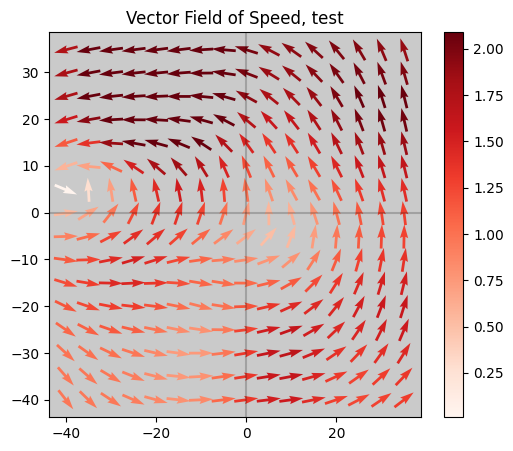

In [151]:
BB = 16

# add Vx
df_dict_list = {}
for k in dfs_names:
    sub_traj_df = open_preprocessed_data(f'{PREPROC_DATA_DIR}/{k}_{DT}_dt.pkl')

    # df_concat = pd.concat(sub_traj_df)
    df_dict_list[k] = sub_traj_df

filtered_V_dfs_dict = {}
for k, df_ in df_dict_list.items():
    subtraj_list = []
    for subtraj in df_:
        subtraj_list.append(add_filtered_V(subtraj))
    filtered_V_dfs_dict[k] = pd.concat(subtraj_list)

df_copy = filtered_V_dfs_dict['tr91']
print(df_copy.shape)
build_vector_field(df_copy, grid_size=BB,
                   title_name='test',
                   z_norm=True,
                   lscale=0.19,
                   color_map='Reds',
                   unsmoothed_colors=False, save=False)

(5659, 3)


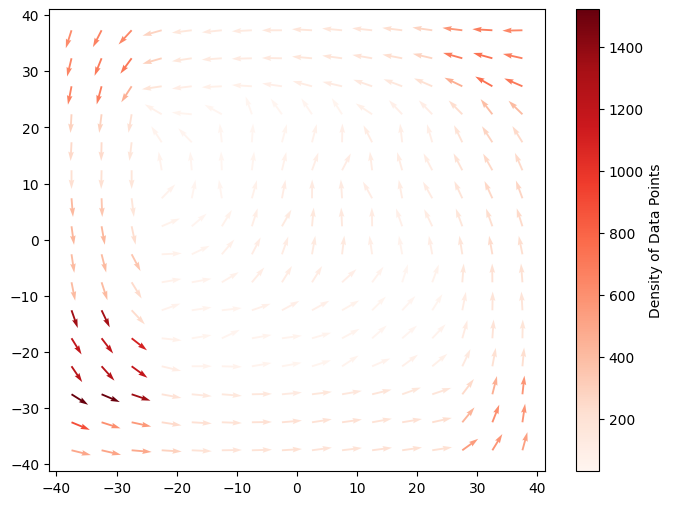

In [153]:
BB = 16
df_test = df_dict['tr91']
df_copy = df_test[['time', 'x', 'y']]
print(df_copy.shape)
xx = df_copy['x'].to_numpy()
yy = df_copy['y'].to_numpy()

plot_vector_field(xx, yy, L=12, n_bins=BB, ax=None)

### More precisely compare our old vectro field version and Lebedev's 

In [ ]:
# TODO not is rush here  